## This is the analysis to cluster colonies and make some plots
- scatter plots to check the available colones and do some cleanup
- colony level gene expression over time
- Bimodality
- difference in gene expression w/o exogenous autoinducer
- colony level spatial gradients

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# prepare for hclust packages
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

In [ ]:
# get data/results path
data_path = '../Data/Delta_Results/'

result_directory = '../Data/Cluster_Results/'
if not os.path.exists(result_directory):
    os.makedirs(result_directory)

In [23]:
# read data
filename = os.path.join(data_path, "las_all_delta_results.csv")
df = pd.read_csv(filename)

### Plot scatter plots to check the available colones

In [25]:
def plot_scatter(df_dict, range_scale):
    '''
    Plot scatter plot for different time stamps for each series
    df_dict: dictionary, key is the series number, value is the dataframe
    range_scale: list, the range of series number
    '''
    for key in range_scale:
        
        df = df_dict[key]
        
        t_snap = [df['frames'].min(), round(df['frames'].max() / 4), round(df['frames'].max() / 2), round((df['frames'].max())*3 / 4), df['frames'].max()]
        filtered_data = df[df['frames'].isin(t_snap)]
        
        # create subplots
        fig, axs = plt.subplots(1, len(t_snap), figsize=(15, 3), sharey=True)  

        # enumerate every time stamp and plot the scatter plot
        for i, snap in enumerate(t_snap):
            filtered_data = df[df['frames'] == snap]
            axs[i].scatter(filtered_data['new_x'], filtered_data['new_y'], alpha=0.5)
            axs[i].set_xlim(0, 2304)  
            axs[i].set_ylim(0, 2304)  
            axs[i].set_aspect('equal', adjustable='box')  
            axs[i].set_xlabel('New X')
            axs[i].set_title(f'Time Stamp {snap}')  
        # set the title of the figure
        fig.suptitle('Scatter Plots for Different Time Stamps')
        fig.text(0, 0.5, f'series{key}', va='center', rotation='vertical')

        plt.tight_layout()

        plt.show()
    
    return None

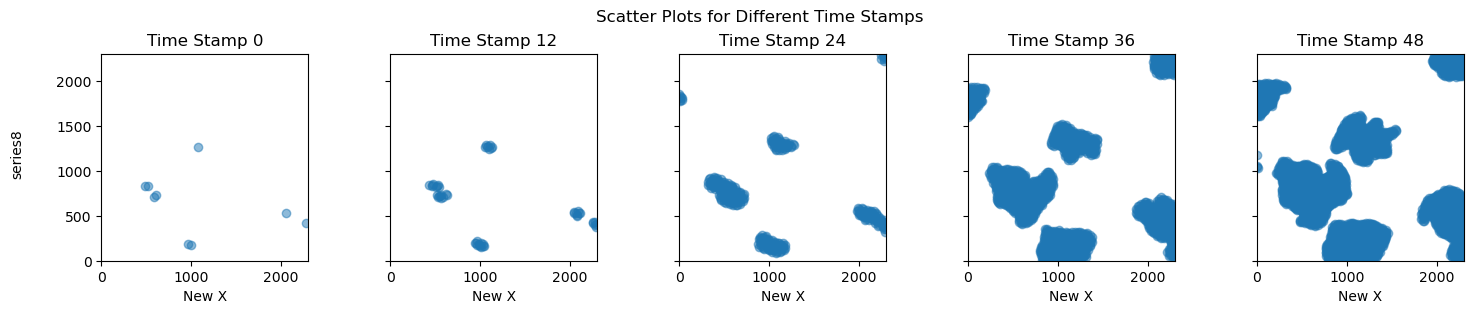

In [26]:
# adjust the x and y coordinates so that they look like the original image
df['new_y'] = 2304 - df['x']
df['new_x'] = df['y']
df_dict = dict(tuple(df.groupby('series')))

# plot the scatter plot
test_with = plot_scatter(df_dict, range(8,9))

## start cleaning

In [28]:
# set the number of serie_num and clusters
serie_num = 8
n_clusters = 2

df_test = df[df['series'] == serie_num].copy()

# # Pre cleaning - filter out some data (optional, based on the data)
# df_test = df_test[df_test['frames'] < 19]
# df_test = df_test[~df_test['id'].isin([4,5])]
# df_test = df_test[df_test['id']!=6]
# df_test = df_test[(df_test['new_x'].between(900,1500)) & (df_test['new_y'].between(750, 1510))]
# df_test = df_test.drop(df_test['new_y'].idxmax())
# df_test = df_test[(df_test['new_y'] > 750)]
# df_test = df_test.drop(df_test[(df_test['new_y'] > 1400) & (df_test['new_x'] < 800) |
#                                (df_test['new_x'] < 750)].index)
# df_test = df_test.drop(df_test[(df_test['new_x'] > 1800) & (df_test['new_y'] > 2000)].index)
# df_test = df_test.drop(df_test[(df_test['new_x'] > 2200) | (df_test['new_y'] > 2150) | (df_test['new_x'] < 550)].index)

# calculate the distance matrix
dist_matrix = pdist(df_test[['x', 'y']], metric='euclidean')

# calculate based on the Ward method
Z = linkage(dist_matrix, method='ward')  

# assign the cluster to the data
df_test['Group'] = fcluster(Z, n_clusters, criterion='maxclust')


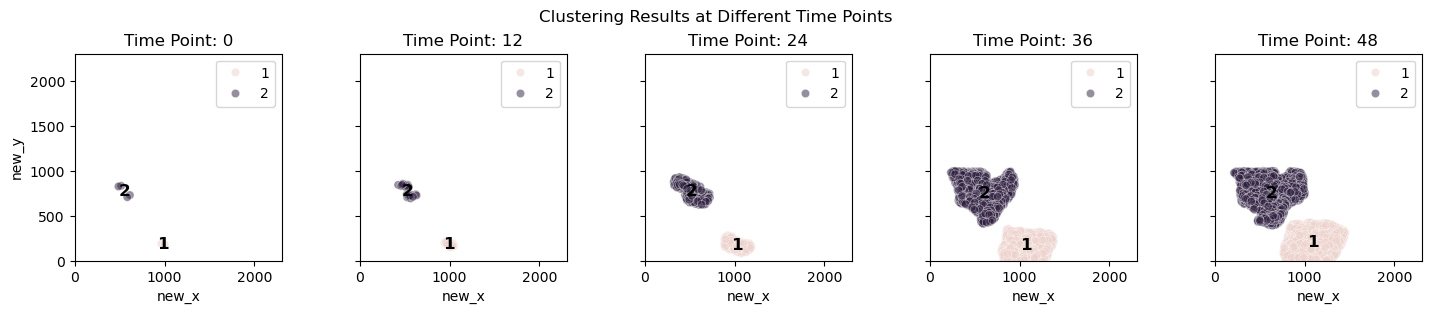

In [29]:
# define the checking datafrane, it should be either df_test or df_xx
df_check = df_test

# 选择你想展示的时间点 (frames)
t_snap = [df_check['frames'].min(), round(df_check['frames'].max() / 4), round(df_check['frames'].max() / 2), round((df_check['frames'].max())*3 / 4), df_check['frames'].max()]
#
# 过滤 DataFrame 只保留选定的时间点
df_filtered = df_check[df_check['frames'].isin(t_snap)]

# 确定子图的行数和列数
num_frames = len(t_snap)

# 创建子图
fig, axes = plt.subplots(1, num_frames, figsize=(15, 3), sharey=True)
#axes = axes.flatten()  # 展平以便于索引

# 绘制每个子图
for i, frame in enumerate(t_snap):
    ax = axes[i] 
    df_frame = df_filtered[df_filtered['frames'] == frame]
    sns.scatterplot(data=df_frame, x='new_x', y='new_y', hue='Group', ax=ax, alpha=0.5)
    ax.set_xlim(0, 2304)  
    ax.set_ylim(0, 2304)  
    ax.set_aspect('equal', adjustable='box')  
    ax.set_title(f'Time Point: {frame}')
    ax.legend(loc='best')
    
   # 为每个簇标注一个数字，标注位置为簇的质心
    for group in df_frame['Group'].unique():
        cluster_data = df_frame[df_frame['Group'] == group]
        centroid_x = cluster_data['new_x'].mean()
        centroid_y = cluster_data['new_y'].mean()
        ax.text(centroid_x, centroid_y, str(group), color='black', fontsize=12, ha='center', va='center', weight='bold')


# 添加整体标题
plt.suptitle("Clustering Results at Different Time Points")

# 调整布局
plt.tight_layout()

# 显示图像
plt.show()


## LasB without AI

In [ ]:
cluster_to_keep = [1, 2, 3, 4, 5]
df_35 = df_test[df_test['Group'].isin(cluster_to_keep)]

df_35 = df_35.drop(df_35[(df_35['Group'].isin([1,5])) & (df_35['frames'] > 28)].index)
df_35 = df_35.drop(df_35[(df_35['Group'] == 4) & (df_35['frames'] > 30)].index)

df_35['cluster'] = df_35['Group'].map({1: 88, 2: 89, 3: 90, 4: 91, 5: 92})

df_35.to_csv(os.path.join(result_directory, 'df_35.csv'), index=False)

In [ ]:
cluster_to_keep = [1]
df_36 = df_test[df_test['Group'].isin(cluster_to_keep)]

df_36['cluster'] = df_36['Group'].map({1: 93})

df_3536 = pd.concat([df_35, df_36])
df_3536.to_csv(os.path.join(result_directory, 'df_3536.csv'), index=False)


In [ ]:
cluster_to_keep = [2]
df_37 = df_test[df_test['Group'].isin(cluster_to_keep)]

# df_37 = df_37.drop(df_37[(df_37['Group'] == 5) & (df_37['frames'] > 26)].index)
# df_37 = df_37.drop(df_37[(df_37['Group'] == 3) & (df_37['frames'] > 22)].index)

df_37['cluster'] = df_37['Group'].map({2: 94})

df_3537 = pd.concat([df_3536, df_37])
df_3537.to_csv(os.path.join(result_directory, 'df_3537.csv'), index=False)

In [ ]:
cluster_to_keep = [1]
df_38 = df_test[df_test['Group'].isin(cluster_to_keep)]

df_38['cluster'] = df_38['Group'].map({1: 95})

df_3538 = pd.concat([df_3537, df_38])
df_3538.to_csv(os.path.join(result_directory, 'df_3538.csv'), index=False)

In [ ]:
cluster_to_keep = [1]
df_39 = df_test[df_test['Group'].isin(cluster_to_keep)]

df_39['cluster'] = df_39['Group'].map({1: 96})

df_3539 = pd.concat([df_3538, df_39])
df_3539.to_csv(os.path.join(result_directory, 'LasB_without_delta_results_clustered.csv'), index=False)

In [ ]:
df_3539['cluster'].value_counts()

## LasI without AI

In [ ]:
cluster_to_keep = [1]
df_30 = df_test[df_test['Group'].isin(cluster_to_keep)]

df_30['cluster'] = df_30['Group'].map({1: 78})

df_30.to_csv(os.path.join(result_directory, 'df_30.csv'), index=False)

In [ ]:
cluster_to_keep = [1, 2, 3]
df_31 = df_test[df_test['Group'].isin(cluster_to_keep)]

df_31['cluster'] = df_31['Group'].map({1: 79, 2: 80, 3: 81})

df_3031 = pd.concat([df_30, df_31])
df_3031.to_csv(os.path.join(result_directory, 'df_3031.csv'), index=False)

In [ ]:
cluster_to_keep = [3]
df_32 = df_test[df_test['Group'].isin(cluster_to_keep)]

df_32 = df_32.drop(df_32[(df_32['id'] == 15)].index)

df_32['cluster'] = df_32['Group'].map({3: 82})

df_3032 = pd.concat([df_3031, df_32])
df_3032.to_csv(os.path.join(result_directory, 'df_3032.csv'), index=False)

In [ ]:
cluster_to_keep = [2, 4]
df_33 = df_test[df_test['Group'].isin(cluster_to_keep)]

df_33 = df_33.drop(df_33[(df_33['id'] == 37)].index)
df_33 = df_33.drop(df_33[(df_33['Group'] == 2) & (df_33['frames'] > 26)].index)

df_33['cluster'] = df_33['Group'].map({2: 83, 4: 84})

df_3033 = pd.concat([df_3032, df_33])
df_3033.to_csv(os.path.join(result_directory, 'df_3033.csv'), index=False)

In [ ]:
cluster_to_keep = [1, 3, 4]
df_34 = df_test[df_test['Group'].isin(cluster_to_keep)]

df_34['cluster'] = df_34['Group'].map({1: 85, 3: 86, 4: 87})

df_3034 = pd.concat([df_30, df_31, df_32, df_33, df_34])
df_3034.to_csv(os.path.join(result_directory, 'LasI_without_delta_results_clustered.csv'), index=False)

## RpsL without AI

In [ ]:
clusters_to_keep = [1, 2, 5]
df_25 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_25 = df_25.drop(df_25[(df_25['Group'] == 1) & (df_25['frames'] > 31)].index)

df_25['cluster'] = df_25['Group'].map({1: 66, 2: 67, 5: 68})

df_25.to_csv(os.path.join(result_directory, 'df_25.csv'), index=False)

In [ ]:
cluster_to_keep = [3, 6]
df_26 = df_test[df_test['Group'].isin(cluster_to_keep)]

df_26['cluster'] = df_26['Group'].map({3: 69, 6: 70})  

df_2526 = pd.concat([df_25, df_26])
df_2526.to_csv(os.path.join(result_directory, 'df_2526.csv'), index=False)

In [ ]:
cluster_to_keep = [1, 3, 4]
df_27 = df_test[df_test['Group'].isin(cluster_to_keep)]

df_27 = df_27.drop(df_27[(df_27['Group'].isin([1,4])) & (df_27['frames'] > 32)].index)

df_27['cluster'] = df_27['Group'].map({1: 71, 3: 72, 4: 73})

df_2527 = pd.concat([df_2526, df_27])
df_2527.to_csv(os.path.join(result_directory, 'df_2527.csv'), index=False)

In [ ]:
cluster_to_keep = [4]
df_28 = df_test[df_test['Group'].isin(cluster_to_keep)]

df_28['cluster'] = df_28['Group'].map({4: 74})

df_2528 = pd.concat([df_2527, df_28])
df_2528.to_csv(os.path.join(result_directory, 'df_2528.csv'), index=False)

In [ ]:
cluster_to_keep = [1, 2, 3]
df_29 = df_test[df_test['Group'].isin(cluster_to_keep)] 

df_29['cluster'] = df_29['Group'].map({1: 75, 2: 76, 3: 77})

df_2529 = pd.concat([df_2528, df_29])
df_2529.to_csv(os.path.join(result_directory, 'rpsL_without_delta_results_clustered.csv'), index=False)

## LasR without AI

In [ ]:
clusters_to_keep = [2,3,4]
df_20 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_20 = df_20.drop(df_20[(df_20['Group'] == 3) & (df_20['frames'] > 17)].index)
df_20 = df_20.drop(df_20[(df_20['Group'] == 4) & (df_20['frames'] > 23)].index)


df_20['cluster'] = df_20['Group'].map({2: 54, 3: 55, 4: 56})

df_20.to_csv(os.path.join(result_directory, 'df_20.csv'), index=False)

In [ ]:
clusters_to_keep = [2,3,4]
df_21 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_21 = df_21.drop(df_21[(df_21['Group'] == 3) & (df_21['frames'] > 23)].index)
df_21 = df_21.drop(df_21[(df_21['Group'] == 2) & (df_21['frames'] > 19)].index)

df_21['cluster'] = df_21['Group'].map({2: 57, 3: 58, 4: 59})

df_2021 = pd.concat([df_20, df_21])
df_2021.to_csv(os.path.join(result_directory, 'df_2021.csv'), index=False)

In [ ]:
clusters_to_keep = [2]
df_22 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_22['cluster'] = df_22['Group'].map({2: 60})

df_2022 = pd.concat([df_2021, df_22])
df_2022.to_csv(os.path.join(result_directory, 'df_2022.csv'), index=False)

In [ ]:
clusters_to_keep = [2, 3]
df_23 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_23 = df_23.drop(df_23[(df_23['Group'] == 2) & (df_23['frames'] > 25)].index)

df_23['cluster'] = df_23['Group'].map({2: 61, 3: 62})

df_2023 = pd.concat([df_2022, df_23])
df_2023.to_csv(os.path.join(result_directory, 'df_2023.csv'), index=False)

In [ ]:
clusters_to_keep = [2, 3, 4]
df_24 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_24 = df_24.drop(df_24[(df_24['Group'] == 3) & (df_24['frames'] > 31)].index)
df_24 = df_24.drop(df_24[(df_24['Group'] == 4) & (df_24['frames'] > 29)].index)

df_24['cluster'] = df_24['Group'].map({2: 63, 3: 64, 4: 65})

df_24 = df_24.drop(df_24[(df_24['new_x'] > 1500) & (df_24['new_y'] < 1000)].index)

df_2024 = pd.concat([df_2023, df_24])
df_2024.to_csv(os.path.join(result_directory, 'LasR_without_delta_results_clustered.csv'), index=False)

In [ ]:
df_2023 = pd.read_csv(os.path.join(result_directory, 'df_2023.csv'))

## LasB with AI

In [ ]:
df_1519 = pd.concat([df_1518, df_19])
df_1519.cluster.value_counts()

df_1519.to_csv(os.path.join(result_directory, 'LasB_with_delta_results_clustered.csv'), index=False)

In [ ]:
clusters_to_keep = [1,4]
df_19 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_19 = df_19.drop(df_19[(df_19['Group'] == 4) & (df_19['frames'] > 39)].index)


df_19['cluster'] = df_19['Group'].map({1: 52, 4: 53})

In [ ]:
df_1518 = pd.concat([df_1517, df_18])
df_1518.to_csv(os.path.join(result_directory, 'df_1518.csv'), index=False)

In [ ]:
df_18 = df_test.copy()

df_18 = df_18.drop(df_18[(df_18['Group'] == 1) & (df_18['frames'] > 31)].index)

df_18['cluster'] = df_18['Group'].map({1: 49, 2: 50, 3: 51})

In [ ]:
df_1517 = pd.concat([df_15, df_16, df_17])
df_1517.to_csv(os.path.join(result_directory, 'df_1517.csv'), index=False)

In [ ]:
clusters_to_keep = [1,2,3,5]
df_17 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_17 = df_17.drop(df_17[(df_17['Group'] == 1) & (df_17['frames'] > 29)].index)
df_17 = df_17.drop(df_17[(df_17['Group'] == 2) & (df_17['frames'] > 35)].index)
df_17 = df_17.drop(df_17[(df_17['Group'] == 5) & (df_17['frames'] > 23)].index)

df_17['cluster'] = df_17['Group'].map({1: 46, 2: 47, 5: 48})

In [ ]:
df_16 = df_test.copy()
df_16['cluster'] = df_16['Group'].map({1: 45})

In [ ]:
df_15 = df_test.copy()
df_15['cluster'] = df_15['Group'].map({1: 44})

## LasI with AI

In [ ]:
df_1014 = pd.concat([df_10, df_11, df_12, df_13, df_14])
df_1014.to_csv(os.path.join(result_directory, 'LasI_with_delta_results_clustered.csv'), index=False)

In [ ]:
df_14 = df_test.copy()
df_14['cluster'] = df_14['Group'].map({1: 43})

In [ ]:
clusters_to_keep = [1,2,6]
df_13 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_13 = df_13.drop(df_13[(df_13['Group'] == 1) & (df_13['frames'] > 31)].index)
df_13 = df_13.drop(df_13[(df_13['Group'] == 2) & (df_13['frames'] > 29)].index)

df_13['cluster'] = df_13['Group'].map({1: 40, 2: 41, 6: 42})

In [ ]:
df_12 = df_test.copy()
df_12['cluster'] = df_12['Group'].map({1: 39})

In [ ]:
df_11 = df_test.copy()
df_11['cluster'] = df_11['Group'].map({1: 38})

In [ ]:
df_10 = df_test.copy()
df_10['cluster'] = df_10['Group'].map({1: 37})

## rpsl with AI

In [ ]:
clusters_to_keep = [2,4,5,6]
df_09 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_09 = df_09.drop(df_09[(df_09['Group'] == 4) & (df_09['frames'] > 26)].index)

df_09['cluster'] = df_09['Group'].map({2: 33, 4: 34, 5: 35, 6: 36})

In [ ]:
clusters_to_keep = [1,2,3,4]
df_05 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_05 = df_05.drop(df_05[(df_05['Group'].isin([3,4]) ) & (df_05['frames'] > 24)].index)

df_05['cluster'] = df_05['Group'].map({1: 19, 2: 20, 3: 21, 4: 22})

In [ ]:
clusters_to_keep = [1,5,6,7]
df_06 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_06 = df_06.drop(df_06[(df_06['Group']==1)  & (df_06['frames'] > 28)].index)
df_06 = df_06.drop(df_06[(df_06['Group']==6 ) & (df_06['frames'] > 34)].index)

df_06['cluster'] = df_06['Group'].map({1: 23, 5: 24, 6: 25, 7: 26})

In [ ]:
# define the clusters to keep (based on next plot)
clusters_to_keep = [1,2,3]
df_07 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_07['cluster'] = df_07['Group'].map({1: 27, 2: 28, 3: 29})

In [ ]:
# define the clusters to keep (based on next plot)
clusters_to_keep = [1,2,3]
df_08 = df_test[df_test['Group'].isin(clusters_to_keep)]

df_08 = df_08.drop(df_08[(df_08['Group'].isin([1,3]) ) & (df_08['frames'] > 30)].index)

df_08['cluster'] = df_08['Group'].map({1: 30, 2: 31, 3: 32})

In [ ]:
df_0509 = pd.concat([df_05, df_06, df_07, df_08, df_09])
df_0509.to_csv(os.path.join(result_directory, 'RpsL_with_delta_results_clustered.csv'), index=False)

## LasR with AI

In [ ]:
# Post cleaning (optional)
df_00 = df_00.drop(df_00[(df_00['new_x'] < 1000 ) & (df_00['new_y'] < 1000)].index)

df_00['cluster'] = df_00['Group'].map({2: 0, 6: 1})

In [ ]:
df_01['cluster'] = df_01['Group'].map({5: 2, 6: 3, 7: 4, 8: 5})

In [ ]:
df_02 = df_02.drop(df_02[(df_02['Group'] == 4 ) & (df_02['frames'] > 29)].index)
df_02 = df_02.drop(df_02[(df_02['Group'] == 7 ) & (df_02['frames'] > 26)].index)
df_02 = df_02.drop(df_02[(df_02['Group'] == 1 ) & (df_02['frames'] > 23)].index)

df_02['cluster'] = df_02['Group'].map({1: 6, 3: 7, 4: 8, 7: 9})

In [ ]:
df_03 = df_03.drop(df_03[(df_03['Group'] == 1 ) & (df_03['frames'] > 25)].index)
df_03 = df_03.drop(df_03[(df_03['Group'].isin([5,6])) & (df_03['frames'] > 23)].index)

df_03['cluster'] = df_03['Group'].map({1: 10, 5: 11, 6: 12, 7: 13, 9: 14})

In [ ]:
df_04 = df_04.drop(df_04[(df_04['Group'] == 1 ) & (df_04['frames'] > 30)].index)
df_04 = df_04.drop(df_04[(df_04['Group'] == 4 ) & (df_04['frames'] > 25)].index)
df_04 = df_04.drop(df_04[(df_04['Group'] == 6 ) & (df_04['frames'] > 26)].index)

df_04['cluster'] = df_04['Group'].map({1: 15, 2: 16, 4: 17, 6: 18})

In [ ]:
df_0004 = pd.concat([df_00, df_01, df_02, df_03, df_04])
df_0004.to_csv(os.path.join(result_directory,'LasR_with_delta_results_clustered.csv'), index=False)

## concatenate and save

In [ ]:
# # Post cleaning (optional)

# df_00 = df_00.drop(df_00[(df_00['new_x'] < 1000 ) & (df_00['new_y'] < 1000)].index)
# df_02 = df_02.drop(df_02[(df_02['Group'] == 4 ) & (df_02['frames'] > 29)].index)
# df_8 = df_8.drop(df_8[df_8['frames'] == 25]['new_y'].idxmax())

In [ ]:
# # concatenate dataframes and save

# df_final = pd.concat([df_final, df_21, df_22, df_23, df_24, 
#                       df_25, df_26, df_27, df_28, df_29])

# df_final.to_csv(os.path.join(result_directory,'LasI_without_delta_results_clustered.csv'), index=False)